In [ ]:
# %pip install openai>1.50.0 langchain>0.3.0 langgraph langchainhub langchain-openai langchain-community langchain-cli langchain_ollama tavily-python>=0.5.0 langchain_nomic nomic[local] langserve faiss-cpu tiktoken pypdf chroma jira google-search-results numexpr beautifulsoup4 scikit-learn

# Introduction to LangGraph

# Nodes

[ Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State.](https://arc.net/l/quote/qbxcjnzg)

In [2]:
from langgraph.graph import START, END
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph
# from IPython.display import Image

builder = StateGraph(dict)

def node1(state: dict, config: RunnableConfig):
    # print("In node: ", config["configurable"]["user_id"])
    return {"results": f"Hello, {state['input']}!"}



builder.add_node(node1)
# Everything starts with the START node
builder.add_edge(START, "node1")
builder.add_edge("node1", END)

graph = builder.compile()

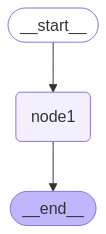

In [3]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [9]:
graph.invoke({"input": "world"})

{'results': 'Hello, world!'}

# Edges

[Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.](https://arc.net/l/quote/eachkdmi)

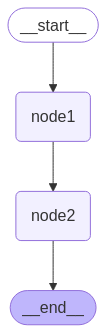

In [4]:
def node1(state: dict):
    print("In node1")
    return state


def node2(state: dict):
    print("In node2")
    return state

builder = StateGraph(dict)

builder.add_node(node1)
builder.add_node(node2)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node2", END)
graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

# Conditional Edge

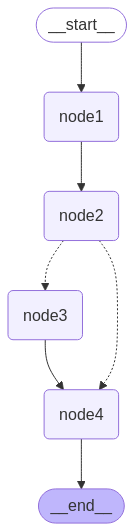

In [5]:
import random
from typing import Literal

def node1(state: dict):
    print("In node1")
    return state


def node2(state: dict):
    print("In node2")
    return state

# Explicitly state this Literal to avoid weird routing edges 
# in your graph
def router_function(state:dict)->Literal["node3", "node4"]:
    if random.randint(3,4)==3:
        return "node3"
    else:
        return "node4"

def node3(state:dict):
    print("In node3")
    return state

def node4(state:dict):
    print("In node4")
    return state    

builder = StateGraph(dict)

builder.add_node(node1)
builder.add_node(node2)
builder.add_node(node3)
builder.add_node(node4)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node3", "node4")
builder.add_conditional_edges("node2", router_function)
builder.add_edge("node4", END)
graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

# State

[State](): A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.

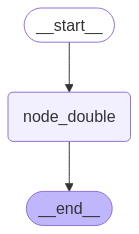

In [6]:
from pydantic import BaseModel, Field

class GraphState(BaseModel):
    number: int
    result: int


builder = StateGraph(GraphState)

def node_double(state: GraphState):
    print("Current state:\n\n")
    print(state)
    return {"result": 2*state.number}

builder.add_node(node_double)

builder.add_edge(START, "node_double")
builder.add_edge("node_double", END)
graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [13]:
graph.invoke({"number": 100, "result": 0})

Current state:


number=100 result=0


{'number': 100, 'result': 200}

Now, we these simple concepts in mind we can set up our first "useful" graph.

In [7]:
from typing import Literal, TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

# Define our state structure
class AgentState(TypedDict):
    query: str
    response: str
    role: str

# Initialize the LLM
llm = ChatOpenAI(model='gpt-4o',temperature=0)

# Define system messages for each profile
engineer_system = """You are a senior software engineer with extensive experience in software development, 
system design, and technical architecture. You focus on technical feasibility, implementation details, 
and best practices in software development. When responding to questions, provide technical insights, 
consider scalability, maintainability, and concrete implementation approaches."""

pm_system = """You are a seasoned product manager with experience in product strategy, user experience, 
and market analysis. You focus on user needs, business value, and product-market fit. When responding 
to questions, consider user impact, business goals, market trends, and prioritization of features 
based on value delivery."""

# Create prompt templates for each role
engineer_prompt = ChatPromptTemplate.from_messages([
    ("system", engineer_system),
    ("human", "{query}")
])

pm_prompt = ChatPromptTemplate.from_messages([
    ("system", pm_system),
    ("human", "{query}")
])

# Define the structure for the router output
class RouterOutput(BaseModel):
    role: Literal["software engineer", "product manager"]

# Create router chain
router_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content="""You are a query classifier that determines whether a question or problem 
    should be handled by a software engineer or a product manager. 

    SOFTWARE ENGINEER if the query is about:
    - Technical implementation details
    - System architecture
    - Code-level problems
    - Performance optimization
    - Security concerns
    - Technical debt
    - Development practices

    PRODUCT MANAGER if the query is about:
    - Feature prioritization
    - User needs and requirements
    - Market analysis
    - Product strategy
    - Business value
    - Roadmap planning
    - Stakeholder management

    You must classify the query as either 'software engineer' or 'product manager'."""),
    HumanMessage(content="{query}")
])

router_chain = router_prompt | llm.with_structured_output(RouterOutput)

def router_llm(state: AgentState):
    return state
    

# Router function to decide between engineer and PM
def route_query(state: AgentState) -> Literal["engineer_node", "pm_node"]:
    result = router_chain.invoke({"query": state["query"]})
    print(f"Router result: {result}" )
    return "engineer_node" if result.role == "software engineer" else "pm_node"

# Node functions
def engineer_node(state: AgentState) -> AgentState:
    query = state["query"]
    print("Engineer processing this query: ", query)
    chain_engineer = engineer_prompt | llm
    response = chain_engineer.invoke({"query": query})
    print(response)
    state['response'] = response.content
    return state

def pm_node(state: AgentState) -> AgentState:
    query = state["query"]
    print("PM processing this query: ", query)
    chain_product_manager = pm_prompt | llm
    response = chain_product_manager.invoke({"query": query})
    print(response)
    state['response'] = response.content
    return state

# Build the graph
builder = StateGraph(AgentState)

# Add nodes
builder.add_node(engineer_node)
builder.add_node(pm_node)
builder.add_node(router_llm)

# Add edges
builder.add_edge(START, "router_llm")
builder.add_conditional_edges("router_llm", route_query)
builder.add_edge("engineer_node", END)
builder.add_edge("pm_node", END)

# Compile the graph
graph = builder.compile()

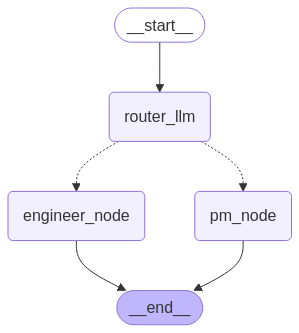

In [8]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [9]:
# Example usage
def process_query(query: str):
    result = graph.invoke({"query": query, "response": ""})
    return result["response"]

# Test examples

technical_question = "How to write a simple Python script to fetch weather  data?"
product_question = "What are the core principles of product management?"

print("\nTechnical Question Response:")
print(process_query(technical_question))

# print("\nProduct Question Response:")
# print(process_query(product_question))


Technical Question Response:
Router result: role='software engineer'
Engineer processing this query:  How to write a simple Python script to fetch weather  data?
content='To write a simple Python script to fetch weather data, you can use a public weather API like OpenWeatherMap. Below is a step-by-step guide to creating a script that fetches weather data for a specific location:\n\n### Step 1: Sign Up for an API Key\n1. Go to the [OpenWeatherMap website](https://openweathermap.org/).\n2. Sign up for a free account.\n3. Once registered, navigate to the API section and subscribe to the "Current Weather Data" API.\n4. Obtain your API key from the dashboard.\n\n### Step 2: Install Required Libraries\nYou\'ll need the `requests` library to make HTTP requests. If you haven\'t installed it yet, you can do so using pip:\n\n```bash\npip install requests\n```\n\n### Step 3: Write the Python Script\nHere\'s a simple script to fetch and display the current weather data for a specified city:\n\n``

# React Agent Loop with LangGraph

In [ ]:
# %pip install langchain
# %pip install langchain-core
# %pip install langchain-openai
# %pip install langgraph

In [ ]:
# uncomment this if running locally
#!pip install python-dotenv
# from dotenv import load_dotenv

# load_dotenv()

# Or if you are in Colab, uncoment below and add your api key
import os
os.environ["OPENAI_API_KEY"] = "your-api-key"

In [10]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

[`MessageState` implements a state for storing messages:](https://arc.net/l/quote/kqoetadt)

```python
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

In [11]:
import os
import requests
from bs4 import BeautifulSoup
# Tools: search and scraping an internet page
from langchain.tools import tool
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.environ["SERPAPI_KEY"]
}


@tool
def search_tool(query: str):
    """Searches the web given a user query and returns the most relevant links"""
    search = GoogleSearch({**serpapi_params, "q": query, "n": 5})
    output = search.get_dict()
    results = output["organic_results"]
    return [r["link"] for r in results]
    
@tool
def scrape_text(url: str):
    """Scrapes text from an internet page"""
    # source: copied from this script by Harrison Chase https://gist.github.com/hwchase17/69a8cdef9b01760c244324339ab64f0c
    try:
        response = requests.get(url)
        #check
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            # Extract all the text from the page
            page_text = soup.get_text(separator=" ", strip=True)
            
            return page_text
        else:
            return f"Failed to retrieve the webpage: Status code: {response.status_code}"
    
    except Exception as e:
        # In case of error print the error message
        print(e)
        return f"Failed to retrieve the webpage: {e}"

tools = [search_tool, scrape_text]
search_tool.invoke("Search the best resources to learn about how to make the best pancakes in the universe.")

['https://www.kingarthurbaking.com/blog/2021/10/26/best-pancake-tips',
 'https://www.youtube.com/watch?v=Lm2dq55phHo&pp=ygUJI19wYW5jYWtl',
 'https://oaklandside.org/2024/11/22/green-house-bakery-pancake-recipe/',
 'https://www.thechoppingblock.com/blog/secrets-for-perfect-pancakes',
 "https://www.dk.com/us/article/where-to-find-the-world's-best-pancakes/",
 'https://www.allrecipes.com/recipe/21014/good-old-fashioned-pancakes/',
 'https://www.youtube.com/watch?v=soByLvI6SSY',
 'https://www.seriouseats.com/pancakes-around-the-world']

In [12]:
search = GoogleSearch({**serpapi_params, "q": 'Pancakes', "n": 5})
output = search.get_dict()

output

{'search_metadata': {'id': '680138fc448a301008fbe398',
  'status': 'Success',
  'json_endpoint': 'https://serpapi.com/searches/54750f8cadcca7e2/680138fc448a301008fbe398.json',
  'created_at': '2025-04-17 17:23:08 UTC',
  'processed_at': '2025-04-17 17:23:08 UTC',
  'google_url': 'https://www.google.com/search?q=Pancakes&oq=Pancakes&sourceid=chrome&ie=UTF-8',
  'raw_html_file': 'https://serpapi.com/searches/54750f8cadcca7e2/680138fc448a301008fbe398.html',
  'total_time_taken': 14.43},
 'search_parameters': {'engine': 'google',
  'q': 'Pancakes',
  'google_domain': 'google.com',
  'device': 'desktop'},
 'search_information': {'query_displayed': 'Pancakes',
  'total_results': 516000000,
  'time_taken_displayed': 0.38,
  'organic_results_state': 'Results for exact spelling',
  'results_for': 'United States'},
 'local_map': {'link': 'https://www.google.com/search?sca_esv=735ec2de70d5467b&tbm=lcl&q=Pancakes&rflfq=1&num=10&sa=X&ved=2ahUKEwiGhIzFyt-MAxVHkIkEHUvoAH8QtgN6BQiBARAD',
  'image': 'h

In [13]:
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)
# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")
# the above is the same as adding: workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)

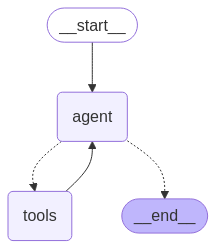

In [14]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [15]:
app.invoke({
    "messages": [
        HumanMessage(content="What are the current LLMs that are hot right now in 2025?.")
        ],
    },config={"configurable": {"thread_id": 42}})

{'messages': [HumanMessage(content='What are the current LLMs that are hot right now in 2025?.', additional_kwargs={}, response_metadata={}, id='0f3bfd16-0d48-4979-ba6e-a0ce2785ae74'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zXysDGwLHfz8mB2DBUGaozeL', 'function': {'arguments': '{"query":"popular LLMs 2025"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 90, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BNNGcW3FIHshIZf8oFUy5XlNhIdM7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6c4010af-d5d7-4b32-96be-1602272fa37f-0', tool_calls=[{'name': 'search_tool', 'args': {'query': 'popular LL